# Exercise 9 by Timo Marks
Den Backpropagation konnte ich auch nach vielen Stunden nicht vollständig funktionfähig implementieren. Aufgrund von weiteren Abgaben in der nächsten Woche, kann ich hier leider keine weitere Zeit investieren.

In [3]:
# Done by Timo Marks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.preprocessing import StandardScaler
import mnist
subplot_keywords = {"xticks": [0,27], "yticks": [0,27]}

## Function for: 
Loading image data    
Converting data matrix to feature vector, and normalization    
Adding a row of dummy ones to the feature vector to avoid offset term    
Normalize data to (0,1]  
Masking Data for specific digits  

In [4]:
def MnistRead():
    train_images = mnist.train_images()
    train_labels = mnist.train_labels()

    test_images = mnist.test_images()
    test_labels = mnist.test_labels()

    print('train_images: ' + str(train_images.shape))
    print('train_labels: ' + str(train_labels.shape))
    print('test_images:  '  + str(test_images.shape))
    print('test_labels:  '  + str(test_labels.shape))
    return [train_images, train_labels, test_images, test_labels]

# Creates num_grid * num_grid subplot of images
def MnistShow(images, num_grid_row = 4, num_grid_column = 4):
    plt.set_cmap("gray")
    fig, ax = plt.subplots(num_grid_row, num_grid_column, figsize=(3*num_grid_column,3*num_grid_row), sharex=True, sharey=True, subplot_kw = subplot_keywords)
    for i in range(num_grid_row):
        for j in range(num_grid_column):
            ax[i,j].imshow(images[i*num_grid_column+j])
    plt.show()


# Create a feature vector of each image
# One Column = One picture = One feature vector
def matrix2vector(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    # This is wrong: See Note Nr. 1 at the end
    # images = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 

    images = images.transpose()
    # Add dummy ones --> one column now 785 numbers
    images = np.vstack([np.ones(images.shape[1]), images])
    return images

# Inverse transformation of feature vector in image
def vector2matrix(feature_vector, NCol, NRow):
    # Remove dummy ones
    feature_vector = feature_vector[1:]
    feature_vector = feature_vector.transpose()
    return feature_vector.reshape(feature_vector.shape[0], NCol, NRow) # Original shape

# Normalization: Gray Value from 0 to 1
def normalize(images):
    # This is called "normalization" in Matlab but actually you do a standardization (For Ex. 5-7)
    # return (images - images.mean())/images.std()
    # The true normalization between 0 and 1
    return images/np.max(images)

# Array containing only the specific numbers
def masking_data(images, labels, digit):
    digit_mask = labels[0,:] == digit
    images_digit = images[digit_mask]
    digit_mask = np.expand_dims(digit_mask, axis=0)
    labels_digit = labels[digit_mask]

    return [images_digit, labels_digit]

### 1. Read in Data and Visualization

In [5]:
[train_images, train_labels, test_images, test_labels] = MnistRead()
train_images = normalize(train_images)
test_images = normalize(test_images)

# Pick out specific numbers
digit_A = 0
digit_B = 4

# Array containing both numbers
# train_labels_mask = np.asarray(train_labels[:] == digit_A) | (train_labels[:] == digit_B)
# train_images, train_labels = train_images[train_labels_mask,:,:], train_labels[train_labels_mask]

# test_labels_mask = np.asarray(test_labels[:] == digit_A) | (test_labels[:] == digit_B)
# test_images, test_labels = test_images[test_labels_mask,:,:], test_labels[test_labels_mask]

# Explaination: train_labels.shape is (x,)
# When we will use matrix multiplication with dimensions like: (1,x) * (x,1) = scalarproduct
# We cannot use the (x,) vectors and (x,).tranpose yields to (x,)
# Therefore expand dimensions explicitly to (x,1) 
# In numpy (x,) is the vector (or more like a list) and (x,1) a matrix

train_labels = np.expand_dims(train_labels, axis=0)
test_labels = np.expand_dims(test_labels, axis=0)

[train_images_digit_A, train_labels_digit_A] = masking_data(train_images, train_labels, digit_A)
[train_images_digit_B, train_labels_digit_B] = masking_data(train_images, train_labels, digit_B)
[test_images_digit_A, test_labels_digit_A] = masking_data(test_images, test_labels, digit_A)
[test_images_digit_B, test_labels_digit_B] = masking_data(test_images, test_labels, digit_B)

train_images: (60000, 28, 28)
train_labels: (60000,)
test_images:  (10000, 28, 28)
test_labels:  (10000,)


<Figure size 432x288 with 0 Axes>

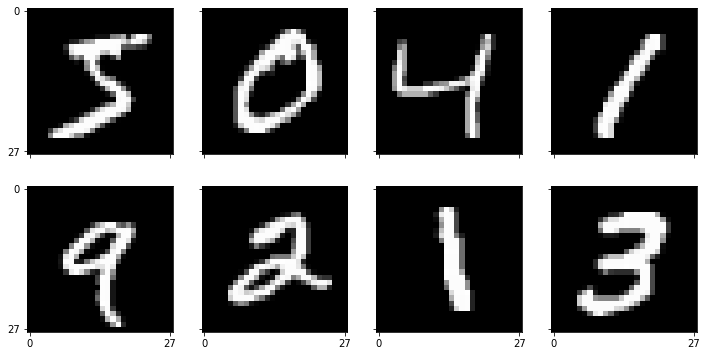

<Figure size 432x288 with 0 Axes>

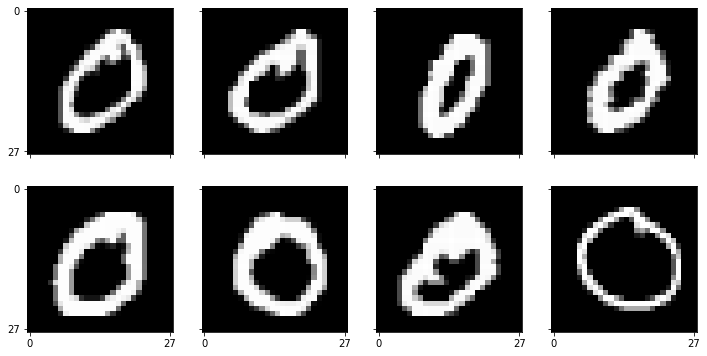

In [6]:
MnistShow(train_images, num_grid_row=2,num_grid_column=4) # Both digits
MnistShow(train_images_digit_A, num_grid_row=2,num_grid_column=4) # Only Digit B

## Task 4 Converting data matrix to feature vector: Test Images
If this fails, the upcoming calculation are not correct. Make sure the images are the same

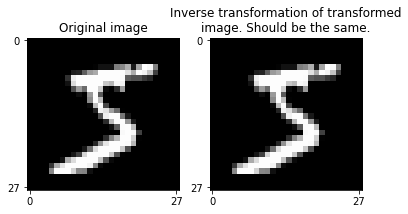

In [7]:
(NFrame, NRow, NCol) = train_images.shape
feature_vectors = matrix2vector(train_images)
images = vector2matrix(feature_vectors, NRow, NCol)

fig, ax = plt.subplots(1,2, figsize=(6,3), subplot_kw=subplot_keywords)
ax[0].imshow(train_images[0])
ax[1].imshow(images[0])
ax[0].set_title("Original image")
ax[1].set_title("Inverse transformation of transformed\nimage. Should be the same.")
plt.plot();

In [8]:
# This is "y hat" on the exercise sheet
def sigmoid(exp_argument):
    return 1.0/(1+np.exp(-exp_argument)) # shape = (1,N)

def sigmoid_derivative(exp_argument):
    return sigmoid(-exp_argument)*(1-sigmoid(-exp_argument))

# Returns a vector of the best class labels for all the samples 
def nn_forward(vec_w, mat_X, NInput, NHidden, NOutput):
    # Number samples = Number Columns = S
    # Number Pixel/Input = Number Columns = NInput
    # mat_X of shape (NInput,N)
    S = mat_X.shape[1]

    # i=input, j=hidden, k=output
    mat_wij = vec_w[0:NInput*NHidden].reshape(NHidden,NInput)
    mat_wjk = vec_w[NInput*NHidden:].reshape(NOutput,NHidden)

    vec_bestclass = np.array([])
    for sample in np.arange(S):
        layer_hidden = mat_wij @ mat_X[:,sample] # shape: (NHidden, NInput) @ (NInput,1) = (NHidden,1)
        layer_hidden = np.expand_dims(layer_hidden,axis=1) # (NHidden,1)
        layer_hidden = sigmoid(layer_hidden)
        # vec_output_hidden = np.append(vec_output_hidden, output_hidden)

        layer_output = mat_wjk @ layer_hidden # shape: (NOutput, NHidden) @ (NHidden,1) = (NOutput,1)
        layer_output = sigmoid(layer_output)

        vec_bestclass = np.append(vec_bestclass, np.argmax(layer_output))
        vec_bestclass = np.expand_dims(vec_bestclass, axis=0)
    return vec_bestclass

# Converts digits to vec of zero and ones: 7 -> (0,0,0,0,0,0,0,1,0,0)
def digit_to_binary_vec(vec_digits, NOutputs):
    vec_digits = vec_digits.flatten()
    mat_vec_binary = np.zeros((NOutputs, len(vec_digits)))
    for i in np.arange(len(vec_digits)):
        mat_vec_binary[vec_digits[i],i] = 1 # shape: (NOutputs, vec_digits)
    return mat_vec_binary

Example for digits_to_binary_vec

In [9]:
print(train_labels[0,0:3])
print(digit_to_binary_vec(train_labels[0,0:3],10))

[5 0 4]
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [10]:
train_images_feature_vec = matrix2vector(train_images)
mat_X = train_images_feature_vec
vec_true = digit_to_binary_vec(train_labels,10)

NInput = 785
NHidden = 10
NOutput = 10
vec_w = np.zeros(NInput*NHidden+NHidden*NOutput)+0.5

In [12]:
# i=input, j=hidden, k=output
vec_X = mat_X[:,1]
vec_true_y = vec_true[:,1]

mat_wij = vec_w[0:NInput*NHidden].reshape(NHidden,NInput)
mat_wjk = vec_w[NInput*NHidden:].reshape(NOutput,NHidden)

layer_hidden = mat_wij @ vec_X
layer_hidden = np.expand_dims(layer_hidden,axis=1) # (NHidden,1)
layer_hidden = sigmoid(layer_hidden)
# vec_output_hidden = np.append(vec_output_hidden, output_hidden)
# print(f"mat_wjk: {mat_wjk.shape}, layer_hidden: {layer_hidden.shape}")
layer_output = mat_wjk @ layer_hidden # shape: (NOutput, NHidden) @ (NHidden,1) = (NOutput,1)
layer_output = sigmoid(layer_output) # (NOutput,1)

y_estimate = layer_output
print(f"layer_output: {layer_output.shape}")
y_estimate[y_estimate[:] == 0] += 10**-10
y_estimate[y_estimate[:] == 1] -= 10**-10

# Cross entropy loss function
L = -1/NOutput * np.sum(vec_true_y*np.log(y_estimate)+(1-vec_true_y)*np.log(1-y_estimate)) # scalar


# grad_L must have same dimensions as vec_w
grad_L = []

# Get all weights for each neuron in hidden layer = one row of mat_wjk (all k's)
# After that concatenate the weights for each neuron in the hidden layer for one vector
vec_true_y = np.expand_dims(vec_true_y, axis=1)
y_diff = y_estimate-vec_true_y
grad_jk = np.zeros(NHidden*NOutput)
grad_jk = 1/NOutput*y_diff*layer_hidden.T
grad_jk = grad_jk.flatten()

sum_w_delta = mat_wjk.T@y_diff
grad_ij = 1/NHidden*sum_w_delta*sigmoid_derivative(layer_hidden)*vec_X.T

grad_ij = np.append(grad_ij, grad_jk)
grad_L = grad_ij.flatten()

layer_output: (10, 1)


Leider habe ich es nicht geschafft, den kompletten Backpropagation Algorithmus zu implementieren. Die groben Fehler, wie falsche Dimensionen bei den Matrix-Multiplikationen sind gelöst, aber die Notation auf dem Aufgabenblatt hat mich verwirrt und wahrscheinlich liegen dort dann die Fehler. Diese Implementation richtet sich stark an das Aufgabenblatt, aber ist durch die for loops sehr langsam.

In [25]:
# Outputs cross entropy loss function and its gradient
def nn_gradient_try1(vec_w, vec_X, vec_true_y, NInput, NHidden, NOutput):
    # i=input, j=hidden, k=output
    vec_X = mat_X[:,1]
    vec_true_y = vec_true[:,1]

    mat_wij = vec_w[0:NInput*NHidden].reshape(NHidden,NInput)
    mat_wjk = vec_w[NInput*NHidden:].reshape(NOutput,NHidden)

    layer_hidden = mat_wij @ vec_X
    layer_hidden = np.expand_dims(layer_hidden,axis=1) # (NHidden,1)
    layer_hidden = sigmoid(layer_hidden)
    # vec_output_hidden = np.append(vec_output_hidden, output_hidden)
    # print(f"mat_wjk: {mat_wjk.shape}, layer_hidden: {layer_hidden.shape}")
    layer_output = mat_wjk @ layer_hidden # shape: (NOutput, NHidden) @ (NHidden,1) = (NOutput,1)
    layer_output = sigmoid(layer_output) # (NOutput,1)

    y_estimate = layer_output
    # print(f"layer_output: {layer_output.shape}")
    y_estimate[y_estimate[:] == 0] += 10**-10
    y_estimate[y_estimate[:] == 1] -= 10**-10

    # Cross entropy loss function
    L = -1/NOutput * np.sum(vec_true_y*np.log(y_estimate)+(1-vec_true_y)*np.log(1-y_estimate)) # scalar


    # grad_L must have same dimensions as vec_w
    grad_L = []
    grad_jk = np.array([])

    # Get all weights for each neuron in hidden layer = one row of mat_wjk (all k's)
    # After that concatenate the weights for each neuron in the hidden layer for one vector
    y_diff = y_estimate.flatten()-vec_true_y.flatten()
    for j in range(NHidden):
        for k in range(NOutput):
            grad_jk_x = 1/NOutput*y_diff[k]*layer_hidden[j]
            grad_jk = np.append(grad_jk, grad_jk_x)

    grad_ij = np.array([])
    for i in range(NInput):
        for j in range(NHidden):
            sum_w_delta = 0
            sum_w_delta = np.dot(mat_wjk[:,j],y_diff)

            grad_ij_x = 1/NHidden*sum_w_delta*sigmoid_derivative(layer_hidden[j])*vec_X[i]
            grad_ij = np.append(grad_ij, grad_ij_x)

    grad_ij = np.append(grad_ij, grad_jk)
    grad_L = np.array(grad_ij)
    grad_L = grad_L.flatten()

    return (L, grad_L)

# Minimizes 
def minimize(loss_function, vec_w, mat_X, vec_true_y, NInput, NHidden, NOutput, learning_rate=0.01, max_Iter=100):
    # Number samples
    S = mat_X.shape[1]
    L_history = np.array([])
    for i in range(max_Iter):
        # Save loss function after each epoch
        [L, grad_L] = loss_function(vec_w, mat_X[:,1], vec_true_y, NInput, NHidden, NOutput)
        L_history = np.append(L_history,L)

        # One whole epoch of all samples
        for sample in range(S):
            [L, grad_L] = loss_function(vec_w, mat_X[:,sample], vec_true_y, NInput, NHidden, NOutput)
            vec_w = vec_w - learning_rate * grad_L

            if (i % 10 == 1):
                learning_rate = learning_rate * 0.8
    # Returns optimal weight vector and history of loss function
    return [vec_w, L_history] 

def compute_accuracy(vec_bestclass, vec_true_label):
    vec_true_false = vec_true_label[vec_bestclass == vec_true_label]
    return len(vec_true_false)/len(vec_true_label[0])


100 Bilder, 2 Epochen dauern schon 70 Sekunden aufgrund der ganzen for loops

In [18]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
mat_X = train_images_feature_vec[:,0:100]
vec_true_y = digit_to_binary_vec(train_labels[:,0:100],10)

NInput = 785
NHidden = 10
NOutput = 10

vec_w_init = np.zeros(NInput*NHidden+NHidden*NOutput)

# Gradient Descent of Cross entropy loss function
nn_gradient_param = [vec_w_init, mat_X, vec_true_y, NInput, NHidden, NOutput]
[vec_w_optimal, L_history] = minimize(nn_gradient_try1, *nn_gradient_param, learning_rate=0.1, max_Iter=2)
vec_bestclass = nn_forward(vec_w_optimal, mat_X, NInput, NHidden, NOutput)
print(f"Accuracy: {compute_accuracy(vec_bestclass, train_labels)}")

Accuracy: 0.0


<ipython-input-15-222e10395168>:75: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  vec_true_false = vec_true_label[vec_bestclass == vec_true_label]


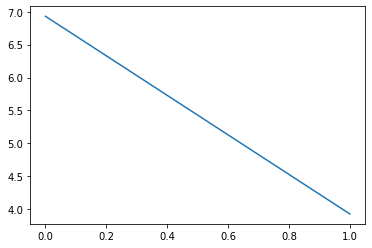

In [20]:
plt.plot(L_history)

Um zu überprüfen, ob mit einem schnelleren Code und nach mehr Epochen das Neuronale Netz doch bessere Ergebnisse liefert, habe ich es nochmal über Matrixmultiplikationen geschrieben. Es ergibt sich aber keine große Verbesserung, außer, dass es viels schneller läuft

In [26]:
def nn_gradient_try2(vec_w, vec_X, vec_true_y, NInput, NHidden, NOutput):
    # i=input, j=hidden, k=output
    vec_X = mat_X[:,1]
    vec_true_y = vec_true[:,1]

    mat_wij = vec_w[0:NInput*NHidden].reshape(NHidden,NInput)
    mat_wjk = vec_w[NInput*NHidden:].reshape(NOutput,NHidden)

    layer_hidden = mat_wij @ vec_X
    layer_hidden = np.expand_dims(layer_hidden,axis=1) # (NHidden,1)
    layer_hidden = sigmoid(layer_hidden)
    # vec_output_hidden = np.append(vec_output_hidden, output_hidden)
    # print(f"mat_wjk: {mat_wjk.shape}, layer_hidden: {layer_hidden.shape}")
    layer_output = mat_wjk @ layer_hidden # shape: (NOutput, NHidden) @ (NHidden,1) = (NOutput,1)
    layer_output = sigmoid(layer_output) # (NOutput,1)

    y_estimate = layer_output
    # print(f"layer_output: {layer_output.shape}")
    y_estimate[y_estimate[:] == 0] += 10**-10
    y_estimate[y_estimate[:] == 1] -= 10**-10

    # Cross entropy loss function
    L = -1/NOutput * np.sum(vec_true_y*np.log(y_estimate)+(1-vec_true_y)*np.log(1-y_estimate)) # scalar


    # grad_L must have same dimensions as vec_w
    grad_L = []

    # Get all weights for each neuron in hidden layer = one row of mat_wjk (all k's)
    # After that concatenate the weights for each neuron in the hidden layer for one vector
    vec_true_y = np.expand_dims(vec_true_y, axis=1)
    y_diff = y_estimate-vec_true_y
    grad_jk = np.zeros(NHidden*NOutput)

    grad_jk = 1/NOutput*y_diff*layer_hidden.T
    grad_jk = grad_jk.flatten()

    sum_w_delta = mat_wjk.T@y_diff
    grad_ij = 1/NHidden*sum_w_delta*sigmoid_derivative(layer_hidden)*vec_X.T

    grad_ij = np.append(grad_ij, grad_jk)
    grad_L = grad_ij.flatten()
    
    return (L, grad_L)


In [27]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
# Kleinerer Datensatz zum Testen
mat_X = train_images_feature_vec[:,0:100]
vec_true_y = digit_to_binary_vec(train_labels[:,0:100],10)

NInput = 785
NHidden = 10
NOutput = 10

vec_w_init = np.zeros(NInput*NHidden+NHidden*NOutput)

# Gradient Descent of Cross entropy loss function
nn_gradient_param = [vec_w_init, mat_X, vec_true_y, NInput, NHidden, NOutput]
[vec_w_optimal, L_history] = minimize(nn_gradient_try2, *nn_gradient_param, learning_rate=0.1, max_Iter=500)
vec_bestclass = nn_forward(vec_w_optimal, mat_X, NInput, NHidden, NOutput)
print(f"Accuracy: {compute_accuracy(vec_bestclass, train_labels)}")

Accuracy: 0.0


<ipython-input-25-3d9d208bed0c>:75: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  vec_true_false = vec_true_label[vec_bestclass == vec_true_label]


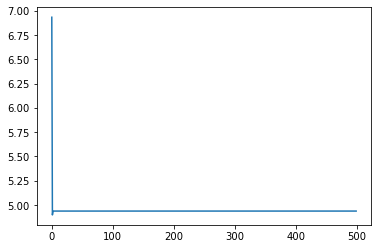

In [28]:
plt.plot(L_history)

# Notes

In [ ]:
# Nr. 1
# Use:
# images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
# images = images.transpose()

# Instead of this without tranpose
# images = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 

# Explaination
images = np.array([[[1.1,1.2],[1.3,1.4]], [[2.1,2.2],[2.3,2.4]], [[3.1,3.2],[3.3,3.4]]])
print(images.shape) # --> Just like (N,28,28) as in mnist
print("Before Reshape\n", images, "\n")
images_correct = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
images_correct = images_correct.transpose()
print("Correct Reshape: Each Column is one feature vector = one image", images_correct, "\n")

images_wrong = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 
print("Wrong Reshape. The .reshape() fills up the new matrix row by row. But we want the images filled up column by column", images_wrong)

(3, 2, 2)
Before Reshape
 [[[1.1 1.2]
  [1.3 1.4]]

 [[2.1 2.2]
  [2.3 2.4]]

 [[3.1 3.2]
  [3.3 3.4]]] 

Correct Reshape: Each Column is one feature vector = one image [[1.1 2.1 3.1]
 [1.2 2.2 3.2]
 [1.3 2.3 3.3]
 [1.4 2.4 3.4]] 

Wrong Reshape. The .reshape() fills up the new matrix row by row. But we want the images filled up column by column [[1.1 1.2 1.3]
 [1.4 2.1 2.2]
 [2.3 2.4 3.1]
 [3.2 3.3 3.4]]
